# Project Navigation Guidelines

In [ ]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 7 (Exp7) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Sampled 12-Sensor RSSI Signature for 12 Locations (100-x%)
>> Tested Data: Sampled 12-Sensor RSSI Signature (x%)
>> Output: Label Coords (Label Model)

>> Experiment 8 (Exp8) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Sampled 12-Sensor RSSI Signature for 12 Locations (100-x%)
>> Tested Data: Sampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

'''
None

# Trial Description

In [14]:
exp = 10
trial = 1
'''
Trial 1
Algorithms use calcLocation mechanic
Resampling done within time period of 2s.
Distance weighting : 1/ (distance^2)
train/test includes original T4 dataset + T9 dataset

'''
None

# Core Libraries

In [2]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# [Exploratory Data Analysis]

# Load Raw Train Dataset

In [5]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E10_All_Proc_270320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
71589  27/3/20   13:59:03   0x0003   177     18,3
71590  27/3/20   13:59:03   0x0006   184     18,3
71591  27/3/20   13:59:03   0x0009   177     18,3
71592  27/3/20   13:59:03   0x0004   177     18,3
71593  27/3/20   13:59:03   0x000C   190     18,3

[71594 rows x 5 columns]


# Resample/Reshape Train Dataset

In [6]:
# Preparation for Date/Time Differences
# ----------------------------------------

# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]
print(readings.head(15))

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E10_resampled_T1.csv')
    print("FILE 'E10_resampled_T1.csv' WRITTEN")

pivoted_readings.tail()

2020-03-27
-11 days, 0:00:00
71593
    DatetimeSec      ID2  RSSI Location
0       54889.0   0x0001   192      1,1
1       54889.0   0x0003   177      1,1
2       54889.0   0x0004   179      1,1
3       54890.0   0x0002   189      1,1
4       54891.0   0x0008   177      1,1
5       54891.0   0x0005   177      1,1
6       54891.0   0x0001   193      1,1
7       54891.0   0x000B   177      1,1
8       54891.0   0x0009   177      1,1
9       54891.0   0x0003   180      1,1
10      54892.0   0x0002   182      1,1
11      54893.0   0x0008   177      1,1
12      54893.0   0x0001   191      1,1
13      54893.0   0x0003   185      1,1
14      54893.0   0x000C   177      1,1
0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
71589    0.0
71590    0.0
71591    0.0
71592    0.0
71593    0.0
Name: DatetimeSec, Length: 71594, dtype: float64
FILE 'E10_resampled_T1.csv' WRITTEN


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
7537.0,"18,3",0.0,177.0,0.0,178.0,0.0,179.0,183.0,182.0,182.0,188.0,193.0,189.0
7538.0,"18,3",0.0,177.0,0.0,0.0,177.0,177.0,185.0,183.0,179.0,190.0,192.0,178.0
7539.0,"18,3",0.0,177.0,0.0,0.0,177.0,0.0,185.0,182.0,180.0,190.5,191.0,179.0
7540.0,"18,3",0.0,0.0,0.0,0.0,0.0,177.0,184.0,190.0,181.0,179.0,191.0,179.0
7541.0,"18,3",0.0,0.0,177.0,177.0,184.0,184.0,0.0,0.0,177.0,0.0,192.0,190.0


In [74]:
resampledDS = pd.read_csv('E10_resampled_T1.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_labels = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)


# #dataset.iloc[rowrange, columnrange]
X = ips_data.to_numpy()
y = ips_labels.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True,test_size=0.3, random_state = 10) 
y_train = y_train.reshape(len(y_train),)

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
print("estimated k value: ", k_value_rootN)
print("X_test: ", X_test)
print("y_test: ", y_test)
print("y_train: ", y_train)

estimated k value:  73
X_test:  [[  0.   0.   0. ... 195. 185. 189.]
 [  0.   0. 177. ... 177. 190. 182.]
 [  0.   0.   0. ... 195. 185. 189.]
 ...
 [  0. 188. 177. ...   0. 177. 183.]
 [  0.   0.   0. ... 196. 184. 188.]
 [177. 185. 191. ...   0. 177. 181.]]
y_test:  [['19,1']
 ['13,7']
 ['19,1']
 ...
 ['8,7']
 ['19,1']
 ['1,13']]
y_train:  ['13,13' '13,7' '13,1' ... '19,1' '18,3' '1,13']


# Parameter Optimisation

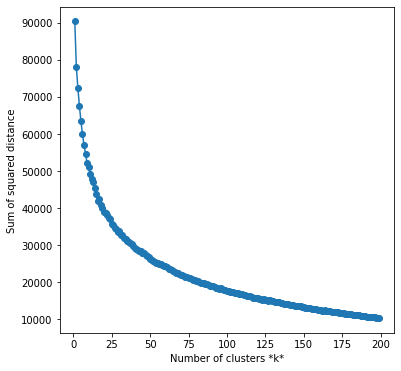

In [106]:
# Run the Kmeans algorithm and get the index of data points clusters
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
sse = []
list_k = list(range(1, 200))
X_std = StandardScaler().fit_transform(X)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

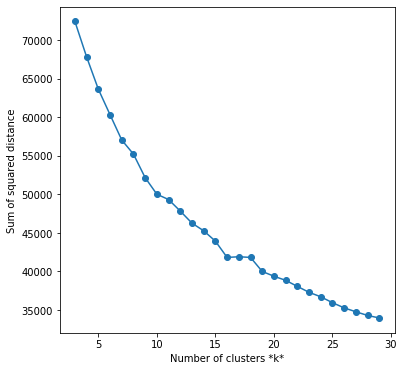

In [105]:
# Run the Kmeans algorithm and get the index of data points clusters
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
sse = []
list_k = list(range(3, 30))
X_std = StandardScaler().fit_transform(X)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [72]:
X = preprocessing.normalize(X)
y = y.reshape(len(y),)
k_range = list(range(1, 64))

def invDist(distances):
    weightList = []
    for dist in distances[0]:
#         print(dist)
        weight = 1 / (1 if (dist == 0) else dist)
        weightList.append(1/weight)
#         print(weight)
    return [weightList]

classifier = KNeighborsClassifier(n_neighbors=3, weights=invDist)
# classifier.fit(X_train, y_train)

param_grid = dict(n_neighbors=k_range)
print(param_grid)

grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

grid.fit(X,y)
print(grid.best_estimator_)
grid.cv_results_

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights=<function invSqDist at 0x12618e560>)


{'mean_fit_time': array([0.00935085, 0.00834348, 0.00783949, 0.0077563 , 0.00843163,
        0.00816581, 0.00790908, 0.00778801, 0.00805571, 0.00788605,
        0.00778041, 0.00787702, 0.00778272, 0.0078635 , 0.00772922,
        0.00784101, 0.00776615, 0.00781579, 0.00784738, 0.00782397,
        0.00798566, 0.00782385, 0.00776944, 0.00801721, 0.00780015,
        0.00786448, 0.00779092, 0.0080709 , 0.00778966, 0.00780592,
        0.00780575, 0.00782564, 0.00780714, 0.00784509, 0.00785213,
        0.00779886, 0.00778818, 0.00795014, 0.00780463, 0.0078218 ,
        0.00784004, 0.00785964, 0.00775943, 0.0079639 , 0.00773349,
        0.00784283, 0.00778103, 0.00778644, 0.00782697, 0.00781817,
        0.00792835, 0.00779214, 0.00775173, 0.00788064, 0.0079747 ,
        0.00790007, 0.00783436, 0.00790412, 0.00785143, 0.00788014,
        0.00785954, 0.00783403, 0.0078537 ]),
 'std_fit_time': array([1.76939689e-03, 9.35677731e-04, 1.91117909e-04, 1.80310946e-04,
        9.44822133e-04, 8.0085349

In [76]:
X = preprocessing.normalize(X)
y = y.reshape(len(y),)
k_range = list(range(1, 64))

def invSqDist(distances):
    weightList = []
    for dist in distances[0]:
#         print(dist)
        weight = 1 / (1 if (dist == 0) else (dist**2))
        weightList.append(1/weight)
#         print(weight)
    return [weightList]

classifier = KNeighborsClassifier(n_neighbors=3, weights=invSqDist)
# classifier.fit(X_train, y_train)

param_grid = dict(n_neighbors=k_range)
print(param_grid)

grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

grid.fit(X,y)
print(grid.best_estimator_)
grid.cv_results_

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights=<function invSqDist at 0x12618ec20>)


{'mean_fit_time': array([0.00909855, 0.00859065, 0.00775411, 0.00771322, 0.00841329,
        0.00778463, 0.00782256, 0.00790195, 0.00782249, 0.00783105,
        0.00786707, 0.00781579, 0.00816987, 0.0078444 , 0.00784674,
        0.00784819, 0.00782433, 0.00793607, 0.00796564, 0.0078779 ,
        0.00788047, 0.00784948, 0.00785902, 0.00777659, 0.00780778,
        0.00780041, 0.00779867, 0.00779617, 0.00788181, 0.00779035,
        0.00777643, 0.00773051, 0.00778511, 0.00779893, 0.00782065,
        0.00778239, 0.00796542, 0.00874252, 0.00839763, 0.00812488,
        0.00859458, 0.00815136, 0.00793796, 0.00865889, 0.0080663 ,
        0.00815105, 0.00789351, 0.00781989, 0.00790095, 0.00775774,
        0.00805159, 0.00783234, 0.00779686, 0.00782444, 0.00817246,
        0.00785637, 0.00787539, 0.00798001, 0.007847  , 0.00785513,
        0.00786488, 0.00788243, 0.00791469]),
 'std_fit_time': array([1.75869130e-03, 9.40633511e-04, 1.59059377e-04, 1.38797059e-04,
        1.17426802e-03, 1.2024101

# KNN Algorithm - Distance Calculation

In [8]:
#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

# KNN Algorithm - Determining Neighbours

In [9]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [10]:
# Get Neighbours
outArray = []
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 189.0, 183....","[19,1]","[([0.0, 0.0, 0.0, 183.0, 0.0, 177.0, 190.0, 18..."
1,1,"[0.0, 0.0, 177.0, 178.0, 0.0, 181.0, 187.0, 19...","[13,7]","[([0.0, 0.0, 177.0, 178.0, 0.0, 181.0, 187.0, ..."
2,2,"[0.0, 0.0, 0.0, 183.0, 0.0, 177.0, 191.0, 180....","[19,1]","[([0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 190.0, 18..."
3,3,"[184.0, 186.0, 189.0, 180.0, 180.0, 0.0, 179.0...","[1,13]","[([179.0, 191.0, 183.0, 188.0, 192.0, 0.0, 180..."
4,4,"[0.0, 179.0, 181.0, 178.0, 0.0, 0.0, 0.0, 180....","[13,13]","[([0.0, 192.0, 187.0, 177.0, 0.0, 0.0, 0.0, 18..."


In [12]:
from collections import Counter
#LOC: outputs for each [x,y] in label, 
#     where (x_n1, y_n1) rep x and y coord of 1st neighbour resp
#     x_out = sum(x_n1, ... x_N) / N, where total neighbours = N
def calcLocation(neighbours): 
    x_out = 0
    y_out = 0
    totalNeighbours = len(neighbours)
    for neighbour in neighbours:
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
#         print("neighbour label: ", labeltuple)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb
        y_out += y_nb
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
    return ((x_out/totalNeighbours) , (y_out/totalNeighbours))

In [13]:
print("NON-WEIGHTED POSITION KNN\n")
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocation(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    print("----------------------------")

NON-WEIGHTED POSITION KNN

test location:  (19, 1)
calculalated location:  (18.205479452054796, 2.589041095890411)
distance error:  1.7766019547258598
----------------------------
test location:  (13, 7)
calculalated location:  (15.520547945205479, 4.945205479452055)
distance error:  3.2519751637663874
----------------------------
test location:  (19, 1)
calculalated location:  (18.21917808219178, 2.5616438356164384)
distance error:  1.7459708865409314
----------------------------
test location:  (1, 13)
calculalated location:  (2.232876712328767, 6.095890410958904)
distance error:  7.013324048216495
----------------------------
test location:  (13, 13)
calculalated location:  (8.547945205479452, 7.438356164383562)
distance error:  7.1240911032681025
----------------------------


In [18]:
k_value_knn = k_value_rootN // 2 // 2
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocation(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationRes = calcLocation(neighbors)
    locArray.append(calcLocationRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationRes))


resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['pred_location'] = locArray
resultsKNN['label'] = labelArray 
resultsKNN['error'] = errorArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E10_KNN_T1_k18.csv has been written.


,index,data,pred_location,label,error
0,0,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 189.0, 183....","(19.0, 1.0)","19,1",0.000000
1,1,"[0.0, 0.0, 177.0, 178.0, 0.0, 181.0, 187.0, 19...","(17.22222222222222, 5.222222222222222)","13,7",4.581228
2,2,"[0.0, 0.0, 0.0, 183.0, 0.0, 177.0, 191.0, 180....","(19.0, 1.0)","19,1",0.000000
3,3,"[184.0, 186.0, 189.0, 180.0, 180.0, 0.0, 179.0...","(1.3333333333333333, 4.0)","1,13",9.006171
4,4,"[0.0, 179.0, 181.0, 178.0, 0.0, 0.0, 0.0, 180....","(7.944444444444445, 6.777777777777778)","13,13",8.017150
5,5,"[177.0, 177.0, 180.0, 193.0, 184.0, 184.0, 182...","(7.0, 1.0)","7,1",0.000000
6,6,"[179.0, 190.0, 184.0, 187.0, 0.0, 180.0, 0.0, ...","(2.8333333333333335, 10.833333333333334)","7,7",5.661763
7,7,"[177.0, 178.0, 193.0, 0.0, 0.0, 188.0, 178.0, ...","(9.055555555555555, 10.0)","4,10",5.055556
8,8,"[177.0, 179.0, 191.0, 177.0, 185.0, 188.0, 177...","(7.5, 8.5)","4,10",3.807887
9,9,"[178.0, 0.0, 191.0, 177.0, 185.0, 190.0, 177.0...","(7.5, 10.166666666666666)","4,10",3.503966


# Weighted KNN

# Distance Weighted KNN

In [20]:
def calcLocationDistW(neighbours): 
    x_out = 0
    y_out = 0
    total_dist = 0
#     cnt = 1
    for neighbour in neighbours:
#         print("Neighour #: ", cnt)
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
        # distance
        dist_nb = neighbour[1]
        total_dist += ( 1 / ((1 if dist_nb == 0 else dist_nb)**2) ) #adjusted weight : 1/(d^2)
#         print("Neighbour distance: ", dist_nb)
#         print("Total distance: ", total_dist)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb*( 1 / ((1 if dist_nb == 0 else dist_nb)**2) )
        y_out += y_nb*( 1 / ((1 if dist_nb == 0 else dist_nb)**2) )
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
#         cnt += 1
    return ( (x_out/(1 if total_dist == 0 else total_dist)) ,
             (y_out/(1 if total_dist == 0 else total_dist)) )


In [21]:
k_value_dwknn = 3
testRange = 20
for i in range(3):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    print("Record #: ", i+1)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    calcLocationDistWRes = calcLocationDistW(neighbors)
    print("calculalated location: ", calcLocationDistWRes)
    print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistWRes))
    print("---------------------------------------------------------")

Record #:  1
test location:  (19, 1)
calculalated location:  (19.0, 1.0)
distance error:  0.0
---------------------------------------------------------
Record #:  2
test location:  (13, 7)
calculalated location:  (13.0, 7.0)
distance error:  0.0
---------------------------------------------------------
Record #:  3
test location:  (19, 1)
calculalated location:  (19.0, 1.0)
distance error:  0.0
---------------------------------------------------------


In [77]:
k_value_dwknn = 2
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocationDistW(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationDistWRes = calcLocationDistW(neighbors)
    locArray.append(calcLocationDistWRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationDistWRes))

resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['pred_location'] = locArray
resultsDWKNN['label'] = labelArray 
resultsDWKNN['error'] = errorArray

if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
    
resultsDWKNN.head(20)

File E10_DWKNN_T1_k2.csv has been written.


,index,data,pred_location,label,error
0,0,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 189.0, 183....","(19.0, 1.0)","19,1",0.000000e+00
1,1,"[0.0, 0.0, 177.0, 178.0, 0.0, 181.0, 187.0, 19...","(13.0, 6.999999999999999)","13,7",8.881784e-16
2,2,"[0.0, 0.0, 0.0, 183.0, 0.0, 177.0, 191.0, 180....","(19.0, 1.0)","19,1",0.000000e+00
3,3,"[184.0, 186.0, 189.0, 180.0, 180.0, 0.0, 179.0...","(6.939342242441475, 7.060657757558526)","1,13",8.399498e+00
4,4,"[0.0, 179.0, 181.0, 178.0, 0.0, 0.0, 0.0, 180....","(7.000000000000001, 13.000000000000002)","13,13",6.000000e+00
5,5,"[177.0, 177.0, 180.0, 193.0, 184.0, 184.0, 182...","(7.0, 1.0)","7,1",0.000000e+00
6,6,"[179.0, 190.0, 184.0, 187.0, 0.0, 180.0, 0.0, ...","(4.486830926083263, 9.513169073916737)","7,7",3.554158e+00
7,7,"[177.0, 178.0, 193.0, 0.0, 0.0, 188.0, 178.0, ...","(4.0, 10.0)","4,10",0.000000e+00
8,8,"[177.0, 179.0, 191.0, 177.0, 185.0, 188.0, 177...","(4.804878048780488, 10.804878048780488)","4,10",1.138269e+00
9,9,"[178.0, 0.0, 191.0, 177.0, 185.0, 190.0, 177.0...","(4.0, 10.000000000000002)","4,10",1.776357e-15


# Data Analysis via Visualisation

Plotting from...
E10_KNN_T1_k1.csv E10_KNN_T1_k18.csv E10_KNN_T1_k36.csv E10_KNN_T1_k73.csv
E10_DWKNN_T1_k1.csv E10_DWKNN_T1_k18.csv E10_DWKNN_T1_k36.csv E10_DWKNN_T1_k73.csv
2260


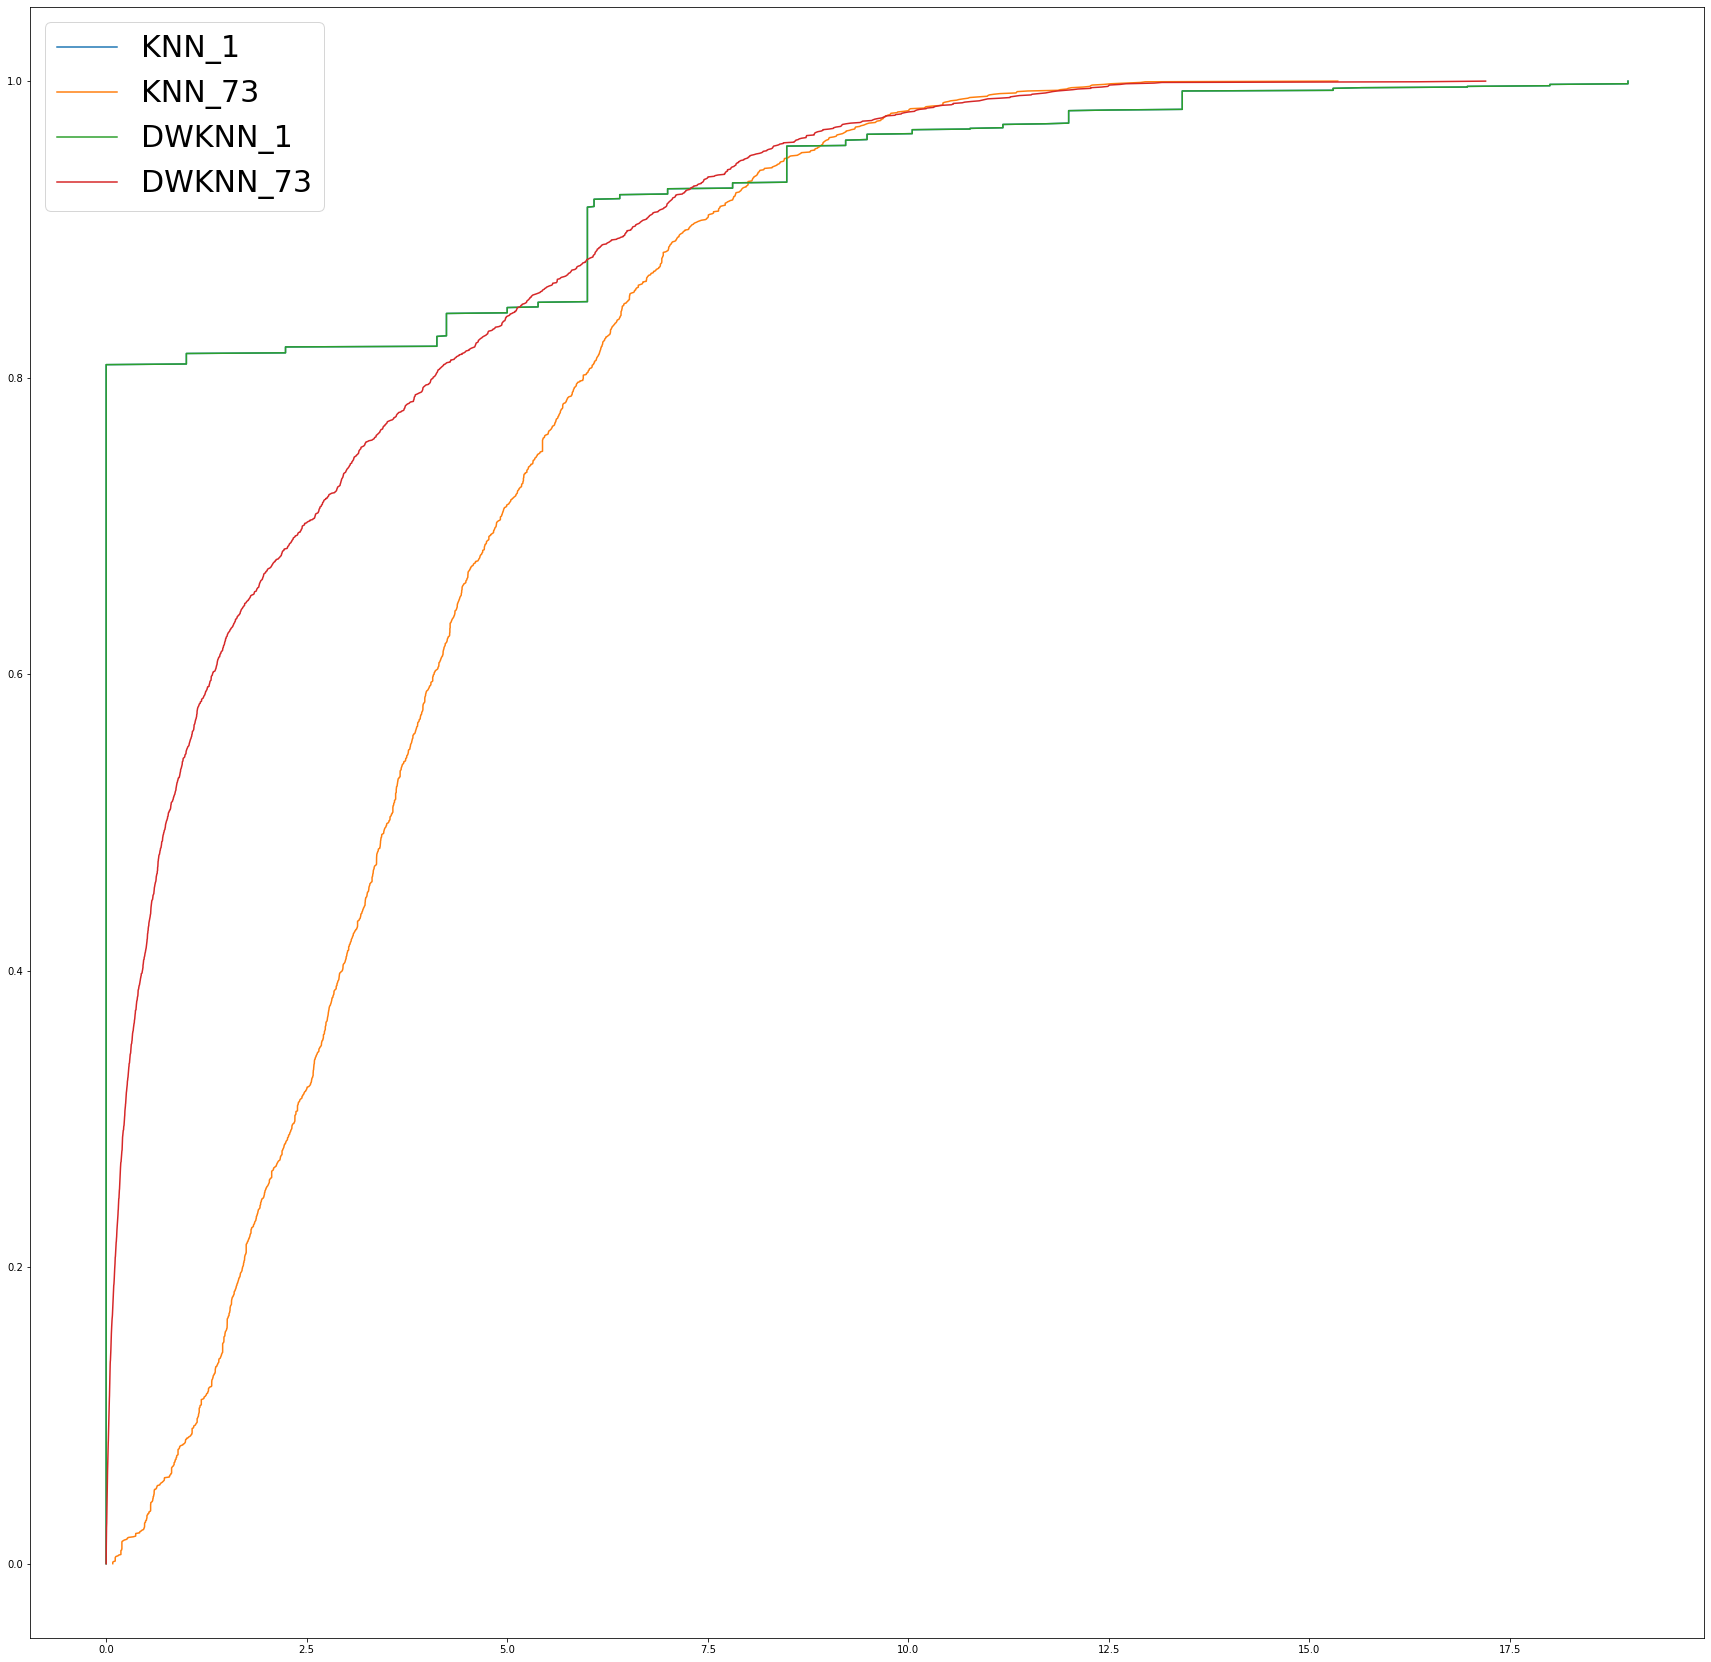

In [88]:
kvalList = [1 , 18, 36, 73]
KNN_kcomp1File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[0])+'.csv')
KNN_kcomp2File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[1])+'.csv')
KNN_kcomp3File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')
KNN_kcomp4File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[3])+'.csv')

DWKNN_kcomp1File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[0])+'.csv')
DWKNN_kcomp2File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[1])+'.csv')
DWKNN_kcomp3File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')
DWKNN_kcomp4File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[3])+'.csv')

print("Plotting from...")
print(KNN_kcomp1File, KNN_kcomp2File, KNN_kcomp3File, KNN_kcomp4File)
print(DWKNN_kcomp1File, DWKNN_kcomp2File, DWKNN_kcomp3File, DWKNN_kcomp4File)


fig= plt.figure(figsize=(30,30))

KNN_kcomp1 = pd.read_csv(KNN_kcomp1File)
errorDf = pd.DataFrame(index = range(len(KNN_kcomp1.values)))
error = KNN_kcomp1['error']
errorDf["knn_k"+str(kvalList[0])+"_error"] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, label = "KNN_"+str(kvalList[0]))


KNN_kcomp4 = pd.read_csv(KNN_kcomp4File)
error = KNN_kcomp4['error']
errorDf["knn_k"+str(kvalList[3])+"_error"] = error
knn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp4_error),step=1)/(len(knn_kcomp4_error)-1)
## plotting    
plt.plot(knn_kcomp4_error,cdf, label = "KNN_"+str(kvalList[3]))

#-------------

DWKNN_kcomp1 = pd.read_csv(DWKNN_kcomp1File)
error = DWKNN_kcomp1['error']
errorDf["dwknn_k"+str(kvalList[3])+"_error"] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_"+str(kvalList[0]))


DWKNN_kcomp4 = pd.read_csv(DWKNN_kcomp4File)
error = DWKNN_kcomp4['error']
errorDf["dwknn_k"+str(kvalList[3])+"_error"] = error
dwknn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
## plotting    
plt.plot(dwknn_kcomp4_error,cdf, label = "DWKNN_"+str(kvalList[3]))

# DWKNN_kcomp5 = pd.read_csv('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(15)+'.csv')
# error = DWKNN_kcomp5['error']
# errorDf["dwknn_k"+str(15)+"_error"] = error
# dwknn_kcomp5_error = np.sort(error)
# cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
# ## plotting    
# plt.plot(dwknn_kcomp5_error,cdf, label = "DWKNN_"+str(15))

# additional plot params
plt.legend(loc='best', fontsize = 30)
plt.show()


Plotting from...
E10_KNN_T1_k1.csv E10_KNN_T1_k18.csv E10_KNN_T1_k36.csv E10_KNN_T1_k73.csv
E10_DWKNN_T1_k1.csv E10_DWKNN_T1_k18.csv E10_DWKNN_T1_k36.csv E10_DWKNN_T1_k73.csv


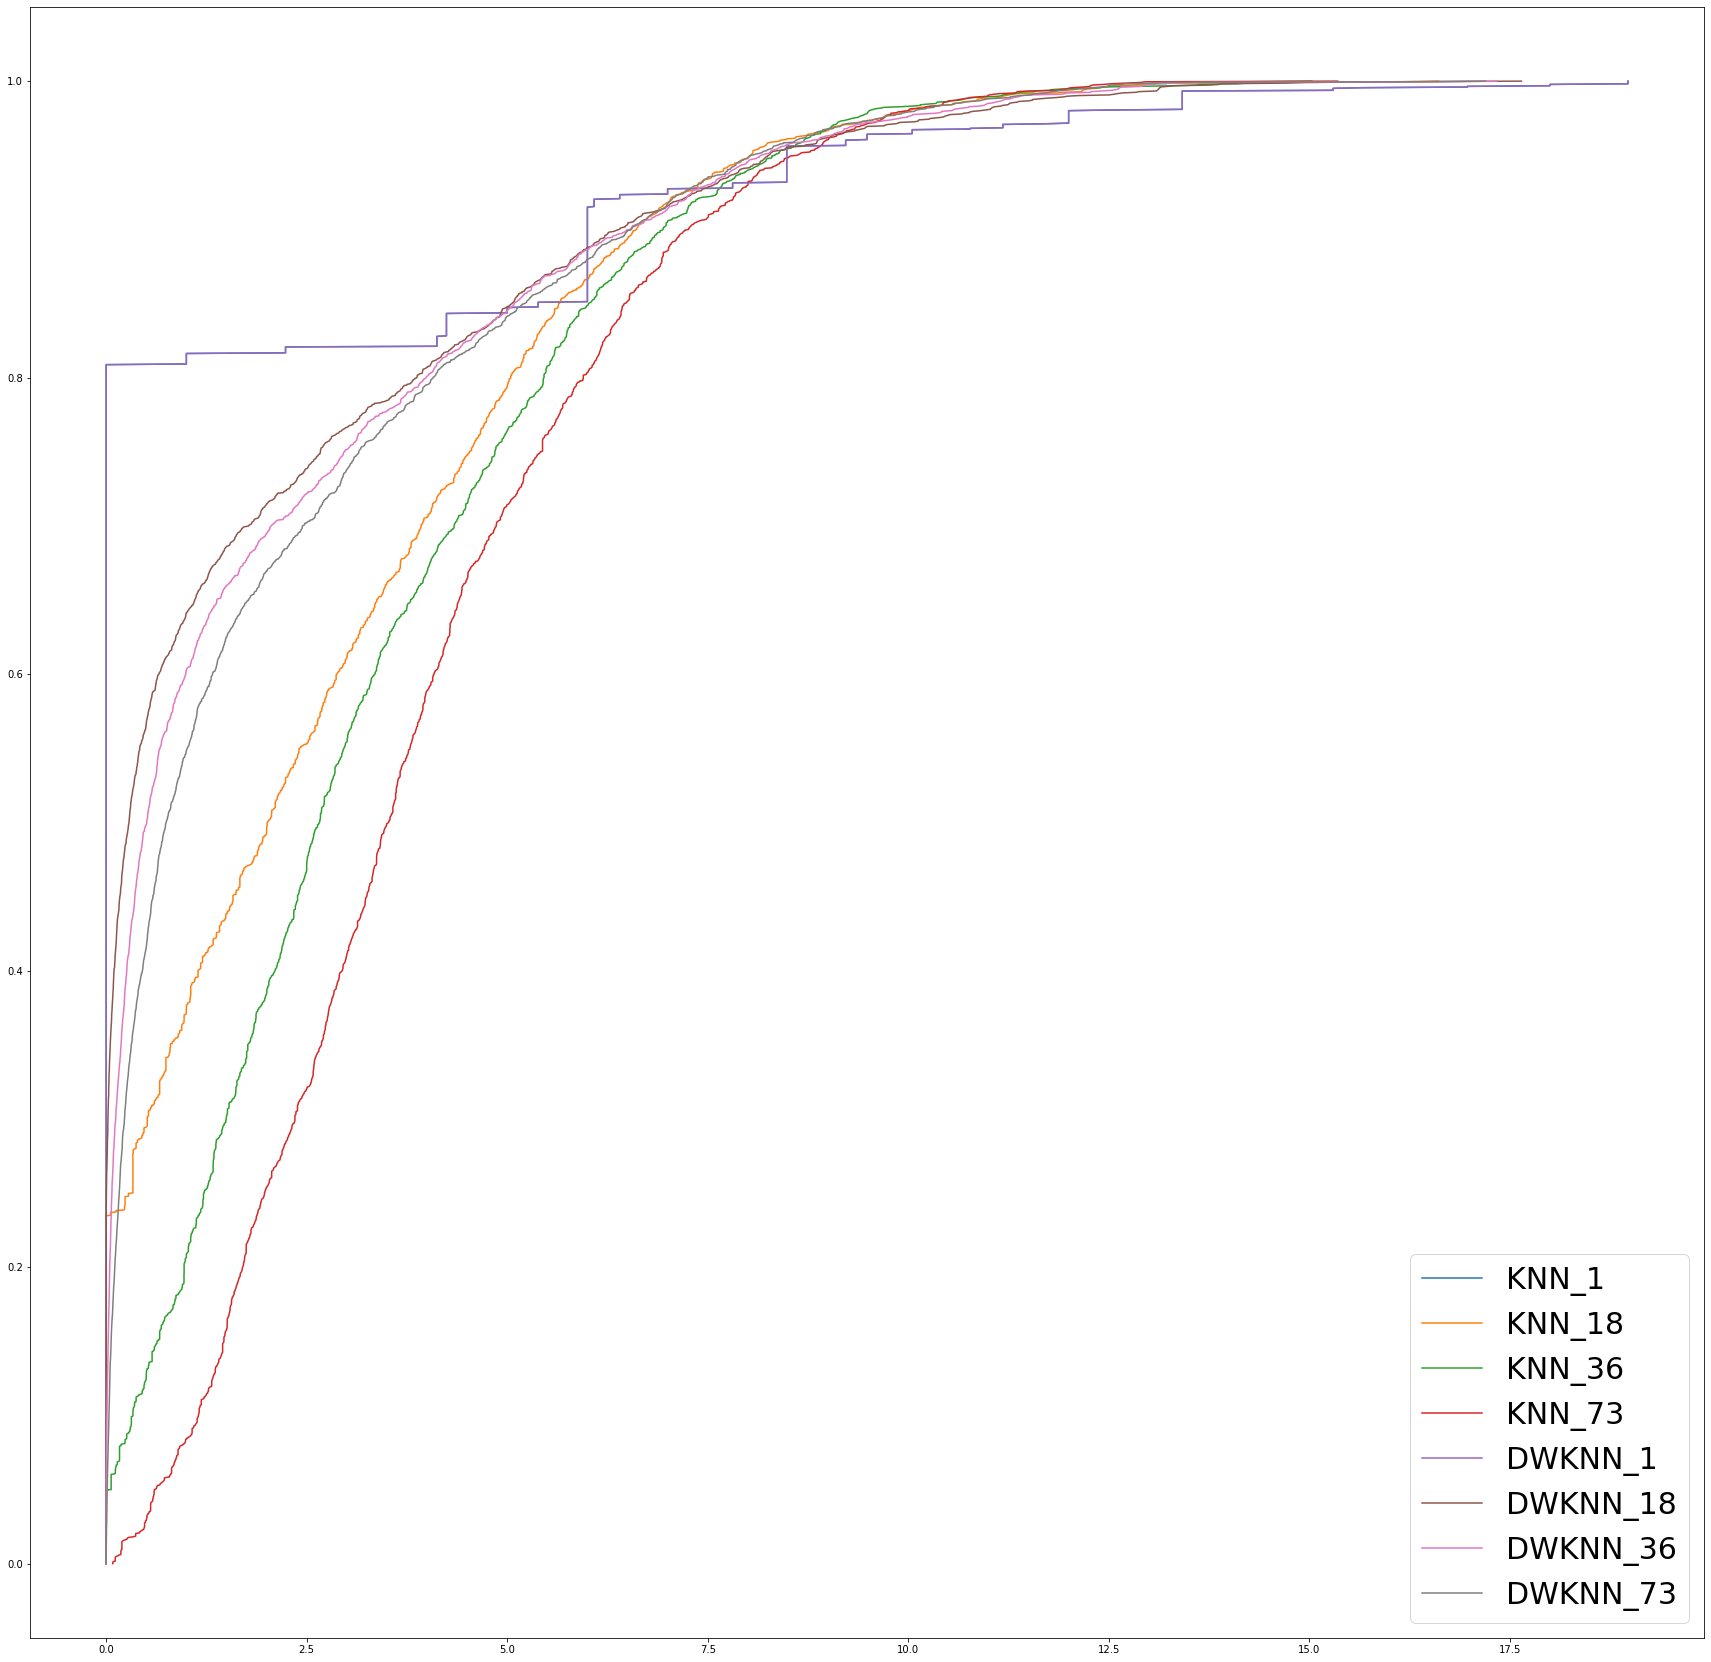

In [90]:
print("Plotting from...")
print(KNN_kcomp1File, KNN_kcomp2File, KNN_kcomp3File, KNN_kcomp4File)
print(DWKNN_kcomp1File, DWKNN_kcomp2File, DWKNN_kcomp3File, DWKNN_kcomp4File)

fig= plt.figure(figsize=(30,30))
errorDf = pd.DataFrame(index = range(len(KNN_kcomp1.values)))

KNN_kcomp1 = pd.read_csv(KNN_kcomp1File)
error = KNN_kcomp1['error']
errorDf["knn_k"+str(kvalList[0])+"_error"] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, label = "KNN_"+str(kvalList[0]))

KNN_kcomp2 = pd.read_csv(KNN_kcomp2File)
error = KNN_kcomp2['error']
errorDf["knn_k"+str(kvalList[1])+"_error"] = error
knn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
## plotting    
plt.plot(knn_kcomp2_error,cdf, label = "KNN_"+str(kvalList[1]))

KNN_kcomp3 = pd.read_csv(KNN_kcomp3File)
error = KNN_kcomp3['error']
errorDf["knn_k"+str(kvalList[2])+"_error"] = error
knn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp3_error),step=1)/(len(knn_kcomp3_error)-1)
## plotting    
plt.plot(knn_kcomp3_error,cdf, label = "KNN_"+str(kvalList[2]))

KNN_kcomp4 = pd.read_csv(KNN_kcomp4File)
error = KNN_kcomp4['error']
errorDf["knn_k"+str(kvalList[3])+"_error"] = error
knn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp4_error),step=1)/(len(knn_kcomp4_error)-1)
## plotting    
plt.plot(knn_kcomp4_error,cdf, label = "KNN_"+str(kvalList[3]))

#-------------

DWKNN_kcomp1 = pd.read_csv(DWKNN_kcomp1File)
error = DWKNN_kcomp1['error']
errorDf["dwknn_k"+str(kvalList[0])+"_error"] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_"+str(kvalList[0]))

DWKNN_kcomp2 = pd.read_csv(DWKNN_kcomp2File)
error = DWKNN_kcomp2['error']
errorDf["dwknn_k"+str(kvalList[1])+"_error"] = error
dwknn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
## plotting    
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_"+str(kvalList[1]))

DWKNN_kcomp3 = pd.read_csv(DWKNN_kcomp3File)
error = DWKNN_kcomp3['error']
errorDf["dwknn_k"+str(kvalList[2])+"_error"] = error
dwknn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp3_error),step=1)/(len(dwknn_kcomp3_error)-1)
## plotting    
plt.plot(dwknn_kcomp3_error,cdf, label = "DWKNN_"+str(kvalList[2]))

DWKNN_kcomp4 = pd.read_csv(DWKNN_kcomp4File)
error = DWKNN_kcomp4['error']
errorDf["dwknn_k"+str(kvalList[3])+"_error"] = error
dwknn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
## plotting    
plt.plot(dwknn_kcomp4_error,cdf, label = "DWKNN_"+str(kvalList[3]))

# DWKNN_kcomp5 = pd.read_csv('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(2)+'.csv')
# error = DWKNN_kcomp5['error']
# errorDf["dwknn_k"+str(2)+"_error"] = error
# dwknn_kcomp5_error = np.sort(error)
# cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
# ## plotting    
# plt.plot(dwknn_kcomp5_error,cdf, label = "DWKNN_"+str(2))


# additional plot params
plt.legend(loc='best', fontsize = 30)
plt.show()


Median Error:
knn_k1_error       0.000000
knn_k18_error      2.010387
knn_k36_error      2.660220
knn_k73_error      3.520641
dwknn_k1_error     0.000000
dwknn_k18_error    0.284810
dwknn_k36_error    0.505805
dwknn_k73_error    0.748375
dtype: float64

0.75 Quantile ERROR:
knn_k1_error       0.000000e+00
knn_k18_error      4.529225e+00
knn_k36_error      4.846486e+00
knn_k73_error      5.419765e+00
dwknn_k1_error     8.881784e-16
dwknn_k18_error    2.670772e+00
dwknn_k36_error    2.968836e+00
dwknn_k73_error    3.150640e+00
Name: 0.75, dtype: float64

Max Error:
knn_k1_error       18.973666
knn_k18_error      16.614920
knn_k36_error      15.030473
knn_k73_error      15.355010
dwknn_k1_error     18.973666
dwknn_k18_error    17.645553
dwknn_k36_error    17.334623
dwknn_k73_error    17.198356
dtype: float64

Std Error:
knn_k1_error       3.267326
knn_k18_error      2.785822
knn_k36_error      2.611851
knn_k73_error      2.447924
dwknn_k1_error     3.267326
dwknn_k18_error    2.937464
dwk

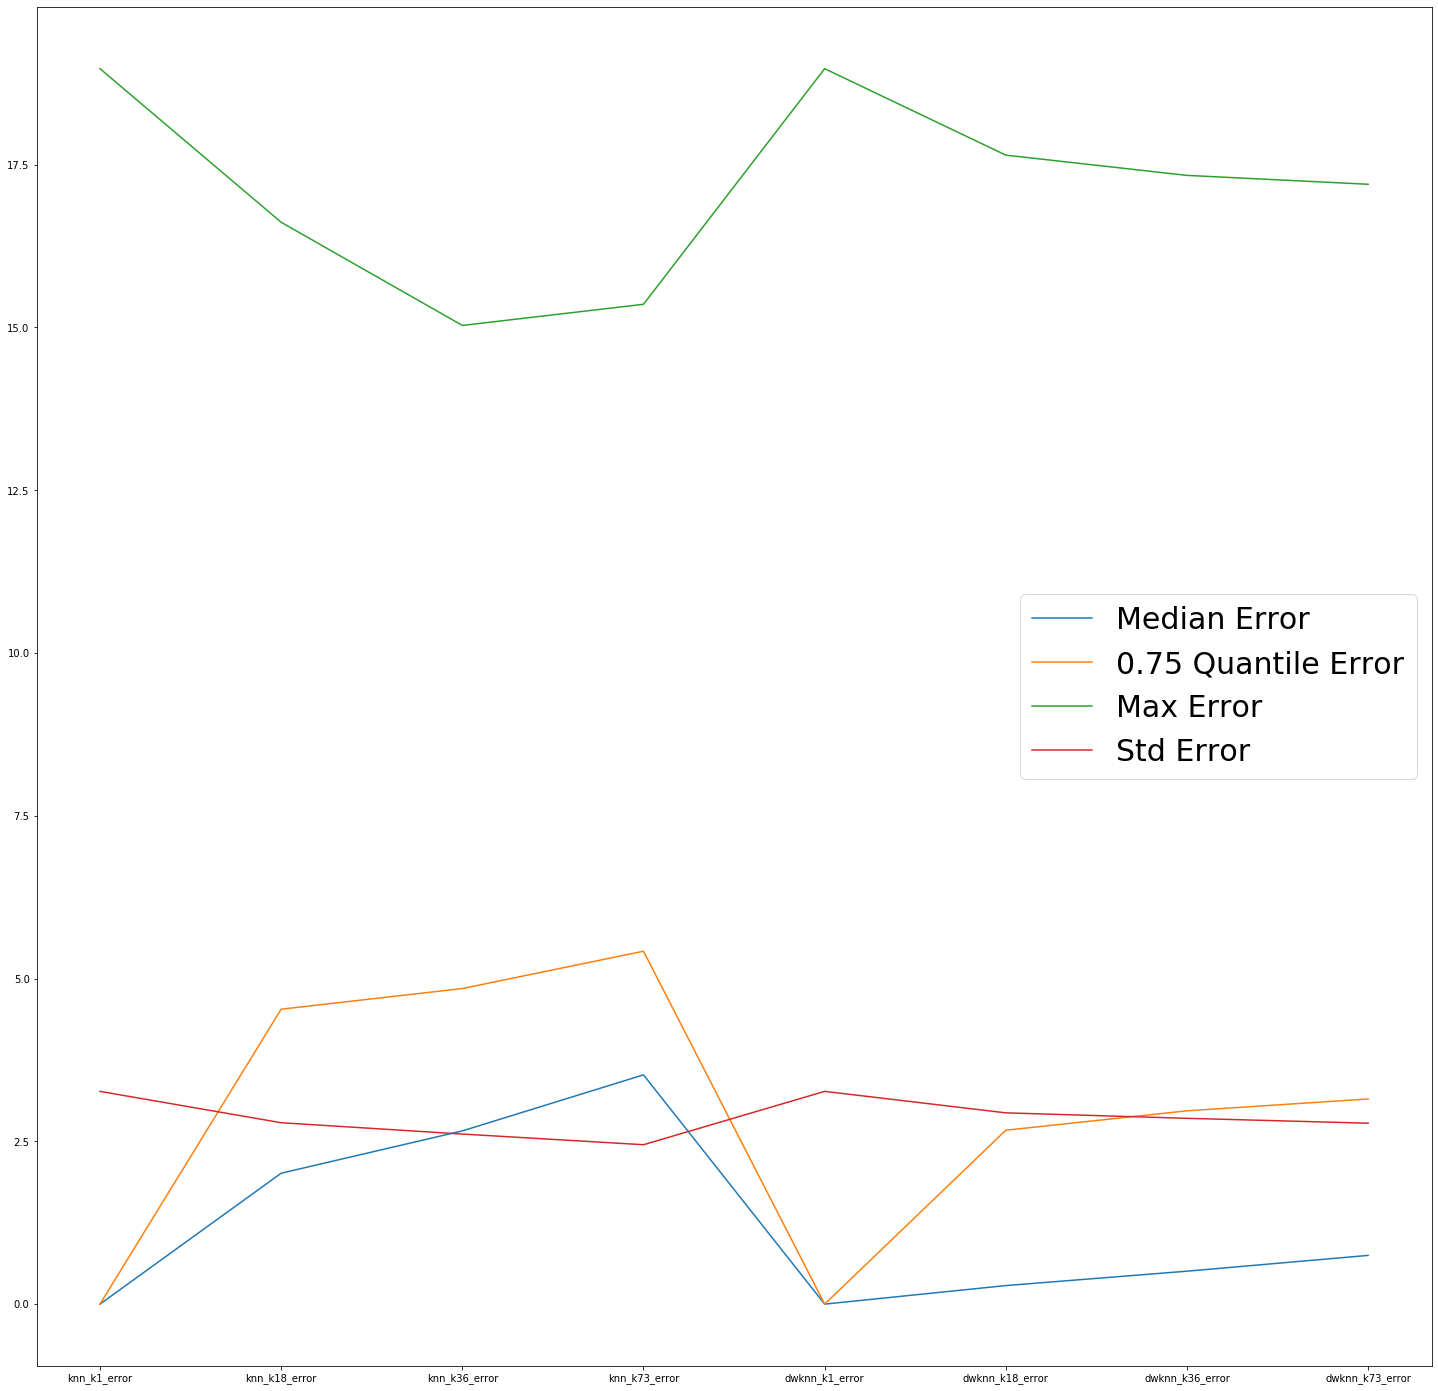

In [91]:
plt.figure(figsize = (25,25))
print("Median Error:")
print(errorDf.median())
plt.plot(errorDf.median(), label = "Median Error")

print("\n0.75 Quantile ERROR:")
print(errorDf.quantile(0.75))
plt.plot(errorDf.quantile(0.75), label = "0.75 Quantile Error")

print("\nMax Error:")
print(errorDf.max())
plt.plot(errorDf.max(), label = "Max Error")

print("\nStd Error:")
print(errorDf.std())
plt.plot(errorDf.std(), label = "Std Error")

plt.legend(loc = 'best', fontsize = 30)
plt.show()

In [101]:
# Create Error File
writeErrSumm = True
fileNameErrSumm = ('E'+str(exp)+'_ErrSummary_T'+str(trial)+'.csv')
meanErrArr = []
medianErrArr = []
quantErrArr = []
maxErrArr = []
stdDevArr = []
for series in errorDf:
    print(series)
    meanErrArr.append(errorDf[series].mean())
    medianErrArr.append(errorDf[series].median())
    quantErrArr.append(errorDf[series].quantile(0.75))
    maxErrArr.append(errorDf[series].max())
    stdDevArr.append(errorDf[series].std())
    
errorSummary = pd.DataFrame(index=range(0,len(errorDf.columns)))
errorSummary.insert(loc=0, column="Mean Error", value=meanErrArr)
errorSummary.insert(loc=1, column="Median Error", value=medianErrArr)
errorSummary.insert(loc=2, column="0.75 Quantile Error", value=quantErrArr)
errorSummary.insert(loc=3, column="Max Error", value=maxErrArr)
errorSummary.insert(loc=4, column="Std Dev Error", value=stdDevArr)
algoType = ["knn_k"+str(kvalList[0]), "knn_k"+str(kvalList[1]), "knn_k"+str(kvalList[2]), "knn_k"+str(kvalList[3]),
                "dwknn_k"+str(kvalList[0]), "dwknn_k"+str(kvalList[1]), "dwknn_k"+str(kvalList[2]), "dwknn_k"+str(kvalList[3])]

errorSummary.insert(loc=0, column="Algorithm", value = algoType)
print(errorSummary)


if (writeErrSumm == True):
    errorSummary.to_csv(fileNameErrSumm, index=False)
    print("File "+fileNameErrSumm+" has been written.")
# print(medianErrArr)

lowestErr = []
for i in range(len(meanErrArr)):
    lowestErr.append(meanErrArr[i] + stdDevArr[i])
print(lowestErr)
lowestErr.sort()
print(lowestErr)



knn_k1_error
knn_k18_error
knn_k36_error
knn_k73_error
dwknn_k1_error
dwknn_k18_error
dwknn_k36_error
dwknn_k73_error
   Algorithm  Mean Error  Median Error  0.75 Quantile Error  Max Error  \
0     knn_k1    1.406406      0.000000         0.000000e+00  18.973666   
1    knn_k18    2.737878      2.010387         4.529225e+00  16.614920   
2    knn_k36    3.260383      2.660220         4.846486e+00  15.030473   
3    knn_k73    3.909621      3.520641         5.419765e+00  15.355010   
4   dwknn_k1    1.406406      0.000000         8.881784e-16  18.973666   
5  dwknn_k18    1.858344      0.284810         2.670772e+00  17.645553   
6  dwknn_k36    1.975312      0.505805         2.968836e+00  17.334623   
7  dwknn_k73    2.111278      0.748375         3.150640e+00  17.198356   

   Std Dev Error  
0       3.267326  
1       2.785822  
2       2.611851  
3       2.447924  
4       3.267326  
5       2.937464  
6       2.853525  
7       2.778652  
File E10_ErrSummary_T1.csv has been written.

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=3, weights=my_distance)
# knn.fit(X_train,y)
# knn.predict([[1]])